In [1]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import numpy as np
import scipy
import scipy.sparse as sp

import matplotlib.pyplot as plt

import os


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_2_vs_4"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = [ 2, 4 ]

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train.shape = (11800, 28, 28, 1)
n train samples = 11800
n test samples = 2014


In [3]:
#Make binary labels

digit_train = np.argmax(y_train, axis=-1)
digit_test = np.argmax(y_test, axis=-1)

y_train = np.zeros((digit_train.shape[0], 1))
y_train[digit_train == included_classes[0], 0] = 0
y_train[digit_train == included_classes[1], 0] = 1

y_test = np.zeros((digit_test.shape[0], 1))
y_test[digit_test == included_classes[0], 0] = 0
y_test[digit_test == included_classes[1], 0] = 1


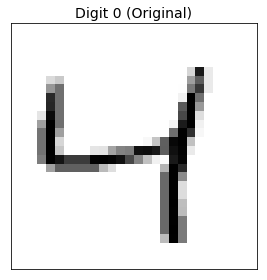

In [4]:
#Plot an example image

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_train[plot_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.title("Digit " + str(int(np.argmax(y_train[plot_ix]))) + " (Original)", fontsize=14)

plt.tight_layout()
plt.show()


In [5]:
#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_bin_train = _binarize_images(x_train, val_thresh=0.5)
x_bin_test = _binarize_images(x_test, val_thresh=0.5)


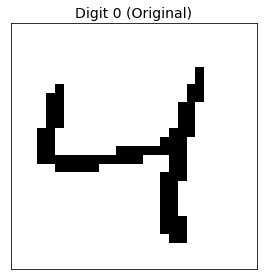

In [6]:
#Plot an example binarized image

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_bin_train[plot_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.title("Digit " + str(int(np.argmax(y_train[plot_ix]))) + " (Original)", fontsize=14)

plt.tight_layout()
plt.show()


In [7]:

batch_size = 32
epochs = 12

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adadelta(),
    metrics=['accuracy']
)

train_history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test)
)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 11800 samples, validate on 2014 samples
Epoch 1/12
11800/11800 [==============================] - 5s 462us/step - loss: 0.0605 - acc: 0.9798 - val_loss: 0.0220 - val_acc: 0.9926
Epoch 2/12
11800/11800 [==============================] - 3s 271us/step - loss: 0.0133 - acc: 0.9962 - val_loss: 0.0119 - val_acc: 0.9955
Epoch 3/12
11800/11800 [==============================] - 3s 270us/step - loss: 0.0089 - acc: 0.9972 - val_loss: 0.0071 - val_acc: 0.9975
Epoch 4/12
11800/11800 [==============================] - 3s 271us/step - loss: 0.0063 - acc: 0.9981 - val_loss: 0.0067 - val_acc: 0.9970
Epoch 5/12
11800/11800 [==============================] - 3s 271us/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.0059 - val_acc: 0.9975
Epoch 6/12
11800/11800 [==

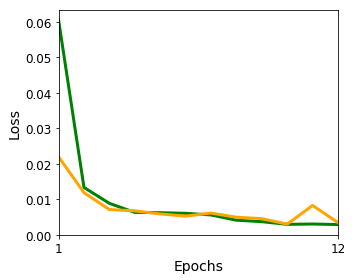

In [8]:

f = plt.figure(figsize=(5, 4))

n_epochs_actual = len(train_history.history['loss'])

plt.plot(np.arange(1, n_epochs_actual + 1), train_history.history['loss'], linewidth=3, color='green')
plt.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_loss'], linewidth=3, color='orange')

plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [10]:

model_name = "mnist_binarized_cnn_digit_2_vs_4"

# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

model.save(model_path)
print('Saved model at %s ' % (model_path))


Saved model at saved_models/mnist_binarized_cnn_digit_2_vs_4.h5 
